## _PandaML_
- Perform detailed _Exploratory Data Analysis_ (EDA) on STT Data.

In [1]:
import sys, os, glob, yaml

In [2]:
import math
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import trackml.dataset
import seaborn as sns

In [4]:
sys.path.append('src')

### _Dataset_

In [5]:
# mu- data (old)
# input_dir = './data_sets/pandaml/data_3.0_7.0_GeV/'

# mu+mu- data (current)
input_dir = './data_sets/ctd2022p/data_10K'

# pbarp data (coming)
# input_dir = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

In [6]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [7]:
event_prefix = file_prefixes[1]

# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000000001 memory usage 0.01 MB


In [8]:
# hits.head()

In [9]:
# tubes.head()

In [10]:
# particles.head()

In [11]:
# truth.head()

### _Read Event_

In [12]:
# TODO: Try to use Event.py (from HepTrkX) instead of SttCSVReader,
# although both are similar in many respects but have diffenct purpose.
from src import SttCSVReader, Draw_Reader_Event

In [13]:
reader = SttCSVReader(input_dir, True, True)

In [14]:
event = reader(4)

In [15]:
event.hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,isochrone,skewed,sector_id
0,1,3.92224,-25.161699,-9.384440,9,8,1123,4,0.349810,1,3
1,2,3.92314,-26.171200,-9.391050,9,9,1321,4,0.285081,1,3
2,3,5.09840,-26.940701,53.185299,9,10,1520,4,0.029671,1,3
3,4,5.53484,-27.698700,43.542702,9,11,1728,4,0.325361,1,3
4,5,5.20436,-29.337500,18.890800,9,12,1949,4,0.273489,1,3


In [16]:
event.tubes.head()

,hit_id,isochrone,depcharge,energyloss,volume_id,layer_id,module_id,skewed,sector_id
0,1,0.349810,14861600.0,14.8616,9,8,1123,1,3
1,2,0.285081,52018500.0,52.0185,9,9,1321,1,3
2,3,0.029671,17653600.0,17.6536,9,10,1520,1,3
3,4,0.325361,18885400.0,18.8854,9,11,1728,1,3
4,5,0.273489,21316000.0,21.3160,9,12,1949,1,3


In [17]:
event.particles.head(10)

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,primary,pt,peta
0,7,-0.894370,0.122221,3.18629,-0.030088,-0.095659,0.059976,-1,53,-211,0.254449,1,0.100279,0.567190
1,6,-0.894370,0.122221,3.18629,-0.115119,0.115502,0.457339,1,30,2212,0.254449,1,0.163074,1.754738
2,5,0.659653,-0.090145,5.10927,0.095602,0.033523,0.098629,1,28,211,0.241083,1,0.101309,0.862546


In [18]:
event.truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_id
0,1,2.29331,-26.164301,20.517099,0.039777,-0.052778,0.042116,1.0,7
1,2,2.70288,-26.691200,20.943899,0.041359,-0.051224,0.042249,1.0,7
2,3,3.65429,-27.781300,21.877600,0.044736,-0.047633,0.042813,1.0,7
3,4,4.34369,-28.481501,22.526699,0.046878,-0.044700,0.043460,1.0,7
4,5,5.17994,-29.233101,23.289700,0.048741,-0.041650,0.044083,1.0,7


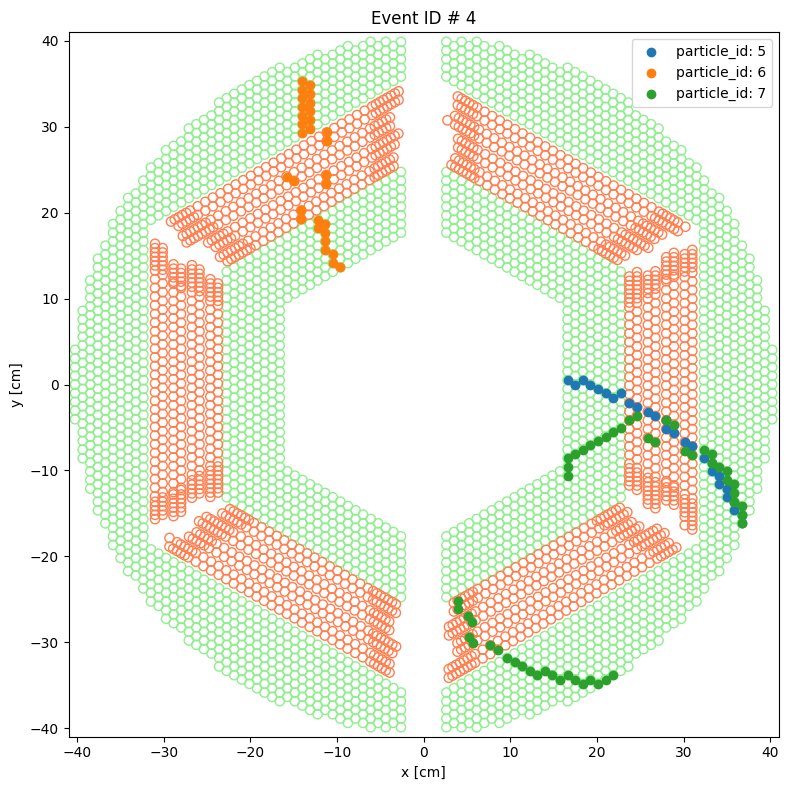

In [19]:
Draw_Reader_Event(data=event,figsize=(8,8),save_fig=False);

- _Drop Duplicates in "Particles"_

In [20]:
# particles = event.particles.copy() # copy() it otherwise event.particles is changed
# particles['nhits'] = particles.groupby(['particle_id'])['nhits'].transform('count')
# particles.drop_duplicates(inplace=True, ignore_index=True)
# particles.head(10)

### _1. Reconstructable Tracks_

- What fraction of particles are reconstructable if each track leave `nhits > 4` with `pt > 50 MeV`

In [21]:
sum_tp, sum_rp = 0, 0

for i in range(len(file_prefixes[:100])):
    event = reader(i)
        
    truth_particles = event.particles.merge(event.truth, on='particle_id', how='left')
    sum_tp += np.unique(truth_particles.particle_id).size
    
    truth_particles = truth_particles[truth_particles.nhits > 5]                 # particles with nhits > 4
    reconstructable_particles = truth_particles[truth_particles.pt > 0.05]       # particles with pt > 50 MeV
    sum_rp += np.unique(reconstructable_particles.particle_id).size

In [22]:
print(f"Total True Tracks: {sum_tp}, Total Reconstructable Tracks: {sum_rp}")
print("Fraction of reconstructable particles (n > 4 and pt > 50MeV): {:.3f}".format((sum_rp/sum_tp)*100))

Total True Tracks: 437, Total Reconstructable Tracks: 330
Fraction of reconstructable particles (n > 4 and pt > 50MeV): 75.515


### _2. Hit Rate and Charge Distribution_

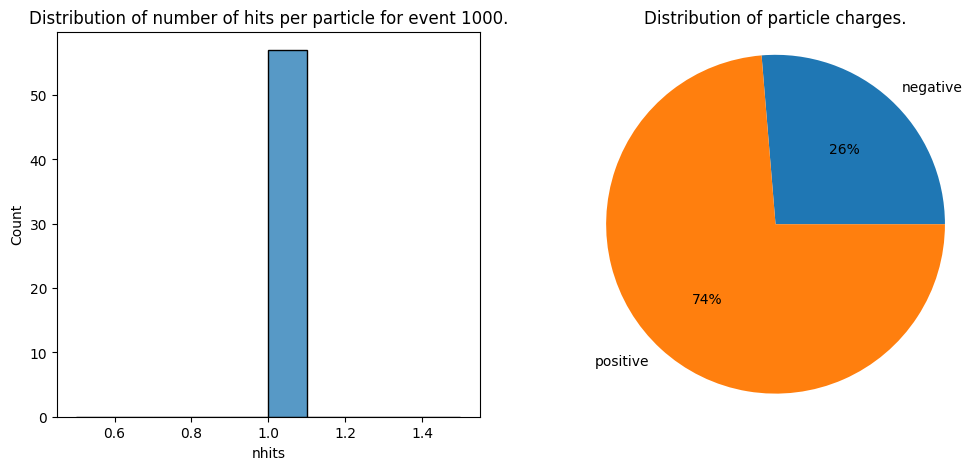

In [23]:
# using the seaborn with pyplot API for subplots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
_ = sns.histplot(data=particles, x='nhits', bins=10) # bins=particles.nhits.max()
plt.title('Distribution of number of hits per particle for event 1000.')

plt.subplot(1, 2, 2)
plt.pie(particles.groupby('q')['vx'].count(),
        labels=['negative', 'positive'],
        autopct='%.0f%%',
        radius=1.1)
plt.title('Distribution of particle charges.')
plt.show()

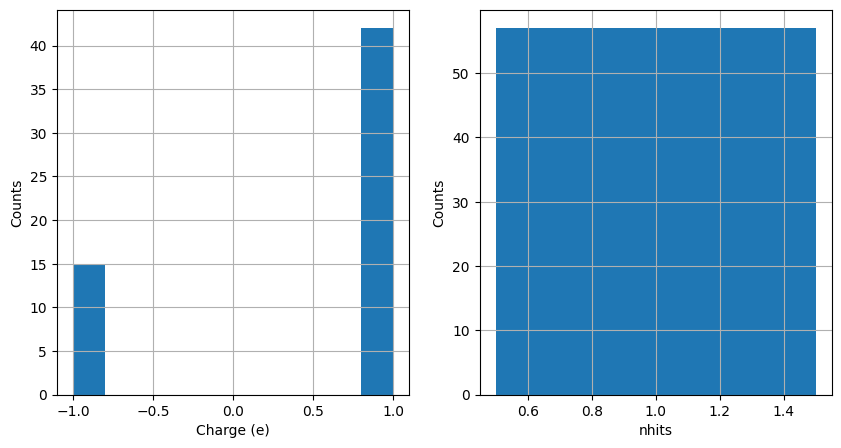

In [24]:
# using the pyplot API for subplots
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
particles.q.hist(bins=10)
plt.xlabel('Charge (e)')
plt.ylabel('Counts')

plt.subplot(1,2,2)
particles.nhits.hist(bins=particles.nhits.max())
plt.xlabel('nhits')
plt.ylabel('Counts')

plt.show()

### _Draw Tracks_

In [25]:
# preprocess hits
# hits['r'] = hits.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1)
hits_ = hits.assign(r=hits.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1))
hits_.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,r
0,1,16.618999,-9.595,35.0,9,0,69,19.189976
1,2,17.493700,-9.090,35.0,9,1,178,19.714402
2,3,18.368401,-9.595,35.0,9,2,292,20.723469
3,4,19.243099,-9.090,35.0,9,3,413,21.282034
4,5,20.117800,-8.585,35.0,9,4,540,21.872999


In [26]:
# we already have sorted hits, lets draw a single track.
data = hits_[truth.particle_id == particles.iloc[1,0]]
data

,hit_id,x,y,z,volume_id,layer_id,module_id,r
0,1,16.618999,-9.595000,35.0,9,0,69,19.189976
1,2,17.493700,-9.090000,35.0,9,1,178,19.714402
2,3,18.368401,-9.595000,35.0,9,2,292,20.723469
3,4,19.243099,-9.090000,35.0,9,3,413,21.282034
4,5,20.117800,-8.585000,35.0,9,4,540,21.872999
5,6,20.992500,-8.080000,35.0,9,5,673,22.493810
6,7,21.867100,-7.575000,35.0,9,6,812,23.141968
7,8,22.741800,-7.070000,35.0,9,7,957,23.815423
8,9,23.751801,-8.206050,35.0,9,8,1131,25.129411
9,10,23.751801,-7.194660,35.0,9,8,1132,24.817558


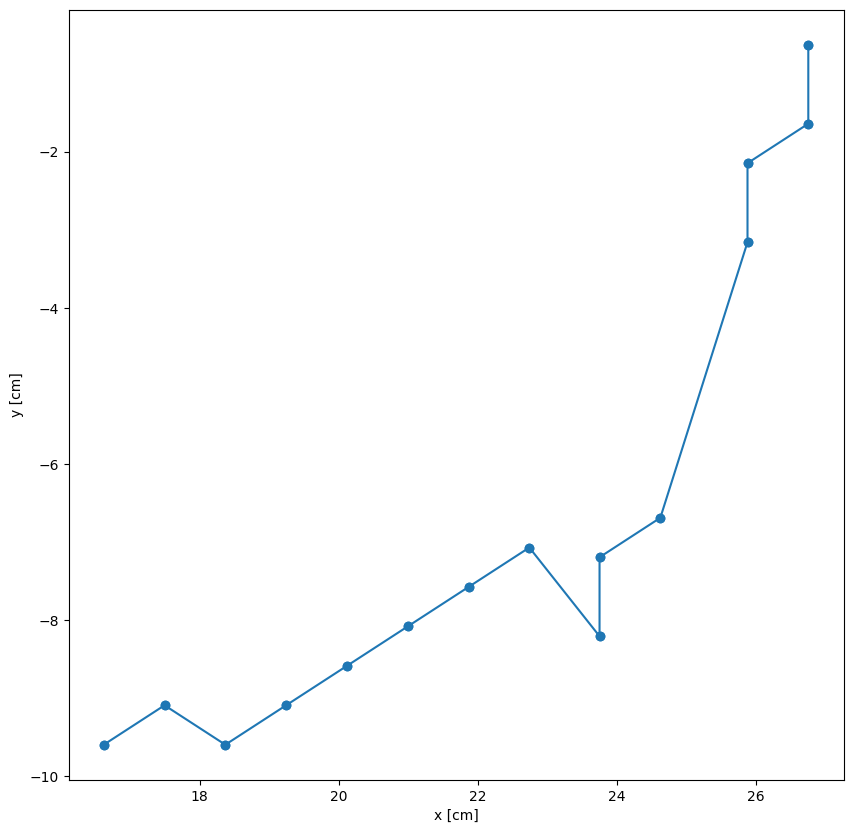

In [27]:
# Using Object Oriented API
plt.close('all')
plt.figure(figsize=(10,10))
plt.scatter(data.x.values, data.y.values)
plt.plot(data.x.values, data.y.values, "-o")
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
#plt.xlim(-40, 40)
#plt.ylim(-40, 40)
# plt.savefig(os.path.join(outdir, "event.png"))
plt.show()

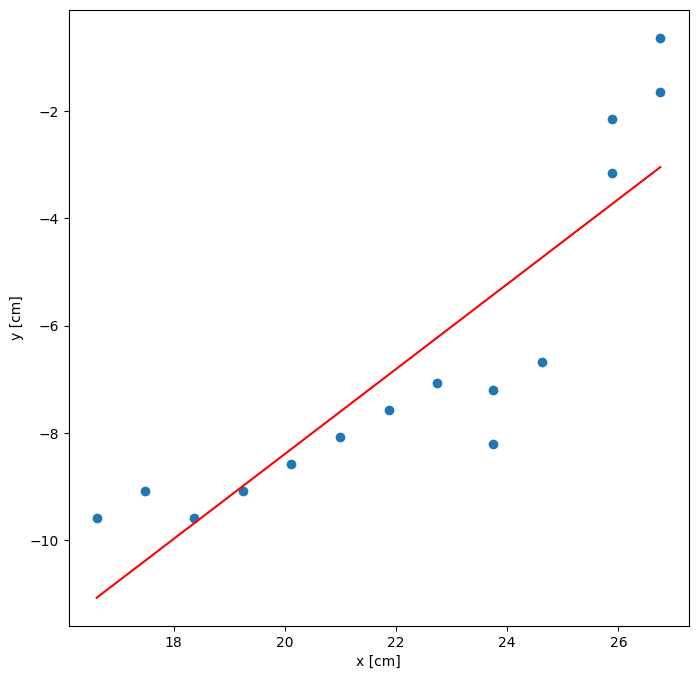

In [28]:
# numpy.polyfit() function
plt.close('all')
plt.figure(figsize=(8,8))

a, b = np.polyfit(data.x, data.y, 1)

plt.scatter(data.x.values, data.y.values)
plt.plot(data.x.values, a*data.x.values+b, 'r')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
#plt.xlim((5, 40))
#plt.ylim((5, 40))
plt.show()

### _Momentum Distributions_

In [29]:
# calculate & assign pt
particles = particles.assign(pt=np.sqrt(particles.px**2 + particles.py**2))

In [30]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,primary,pt
0,7,0.159734,0.060684,1.3698,0.05251,-0.07041,0.016586,-1,1,-211,0.116657,1,0.087834
1,7,0.159734,0.060684,1.3698,0.05251,-0.07041,0.016586,-1,1,-211,0.116657,1,0.087834
2,7,0.159734,0.060684,1.3698,0.05251,-0.07041,0.016586,-1,1,-211,0.116657,1,0.087834
3,7,0.159734,0.060684,1.3698,0.05251,-0.07041,0.016586,-1,1,-211,0.116657,1,0.087834
4,7,0.159734,0.060684,1.3698,0.05251,-0.07041,0.016586,-1,1,-211,0.116657,1,0.087834


In [31]:
particles.pt

0     0.087834
1     0.087834
2     0.087834
3     0.087834
4     0.087834
5     0.087834
6     0.087834
7     0.087834
8     0.087834
9     0.087834
10    0.087834
11    0.087834
12    0.087834
13    0.087834
14    0.087834
15    0.208773
16    0.208773
17    0.208773
18    0.222328
19    0.222328
20    0.222328
21    0.222328
22    0.222328
23    0.362430
24    0.362430
25    0.362430
26    0.000061
27    0.091527
28    0.091527
29    0.091527
30    0.107784
31    0.107784
32    0.107784
33    0.107784
34    0.107784
35    0.107784
36    0.107784
37    0.107784
38    0.107784
39    0.107784
40    0.107784
41    0.107784
42    0.107784
43    0.107784
44    0.107784
45    0.107784
46    0.107784
47    0.107784
48    0.107784
49    0.107784
50    0.107784
51    0.107784
52    0.107784
53    0.107784
54    0.107784
55    0.107784
56    0.107784
Name: pt, dtype: float32

/tmp/ipykernel_681204/3314976617.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


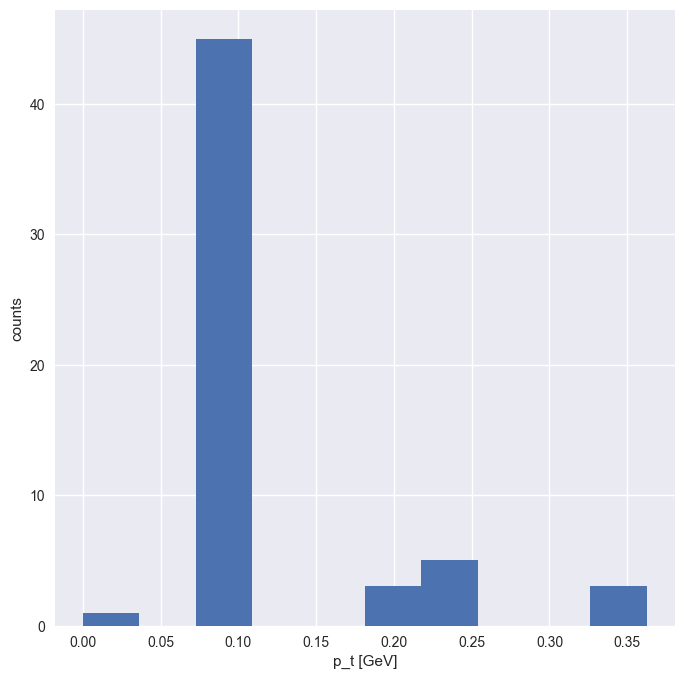

In [32]:
plt.close('all')
plt.style.use('seaborn')
fig = plt.figure(figsize=(8,8))

plt.hist(particles.pt, bins=10)

plt.xlabel('p_t [GeV]')
plt.ylabel('counts')
# plt.xlim((0.1, 1.5))
#plt.ylim((5, 40))
plt.show()

In [33]:
# find average hits per track
print("Average number of hits per tracks: {}".format(hits.hit_id.count()/particles.particle_id.unique().size))

Average number of hits per tracks: 8.142857142857142
